<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/demosaicnet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Mar 30 21:10:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    23W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# ! unzip -q /content/drive/MyDrive/blender_512.zip -d scenes/

# Training Data for Demosaicking-baseline
#### Qian Huang
#### Mar 30



Ideas: start with demosaicking to demonstrate multiframe estimation pipeline. Start with building baseline, and then single frame demosaicking, and then proceed to multiframe demosaicking.

* forward model is easy to model
* pixel map is not the best representation of an image

Goals: 
* model trained on the synthetic data is able to extend to real data
* model trained on local patches works on whole frames
* **model trained on mosaiced image features can predict colored image features**
* **model trained on features of poorly sampled signals can estimate features of finely sampled signals**

Reference: [Deep Joint Demosaicking and Denoising](https://groups.csail.mit.edu/graphics/demosaicnet/data/demosaic.pdf)

Notation: 
* J: ground truth colored frame with higher sampling rate (e.g. 3 x 4H x 4W)
* I: same content, mosaiced frame/features with lower sampling rate (e.g. 1 x H x W)

preprocessing step: 
$$I \rightarrow I_{comp}, J \rightarrow J_{comp}$$

single-frame pipeline: 
$$I_{comp} \rightarrow \text{network} \rightarrow \hat{J}_{comp}$$

multiframe pipeline: 
TBD

**->**baseline pipeline:
$$I \rightarrow \text{demosaicnet} \rightarrow \hat{J}$$




In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = ((npimg - npimg.min())/(npimg.max() - npimg.min()))**0.5
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

### training data generation diagram
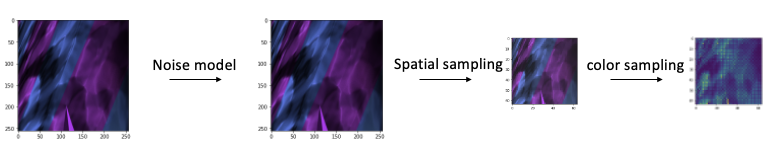

## prepare inputs and outputs

In [5]:
import os
import cv2

class SynDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None):
        self.root = root
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return 1600
        else:
            return 400
    
    def __getitem__(self, index):
        if self.train:
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        else:
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100 + 16), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        # X = self.randomCrop(X)
        X = torch.from_numpy(X.transpose(2, 0, 1)).float()
        return X

    def randomCrop(self, img, size = 64):
        H, W, C = img.shape
        x = np.random.randint(0, H - size + 1)
        y = np.random.randint(0, W - size + 1)
        return img[x:x+size, y:y+size]

trainset = SynDataset(root='/content/scenes', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content/scenes', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

In [6]:
class camMosaicModelTensor:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 2

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        # print(sigma_noise)
        noise = torch.randn_like(img_gt) * sigma_noise
        # print(noise.size(), noise.max(), noise.min())
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        n_batch, c, h, w = img.shape
        bayer_img = torch.zeros(n_batch, 1, h, w)
        bayer_img[:, 0, ::2, ::2] = img[:, 0, ::2, ::2]
        bayer_img[:, 0, 1::2, 1::2] = img[:, 2,::2, ::2]
        bayer_img[:, 0, ::2, 1::2] = img[:, 1, ::2, 1::2]
        bayer_img[:, 0, 1::2, ::2] = img[:, 1, 1::2, ::2]
        return bayer_img

    def spatial_sampling(self, img, pix = 8):
        n_batch, c, h, w = img.shape
        return F.avg_pool2d(img, pix) * pix**2

    
    def develop(self, img_gt):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        img = self.spatial_sampling(img_gt)
        img_noisy = self.noise_model(img)
        sensor_noisy = torch.clamp(torch.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy_float, bayer_noisy_float

In [7]:
dataiter = iter(trainloader)
images = dataiter.next()[:4]

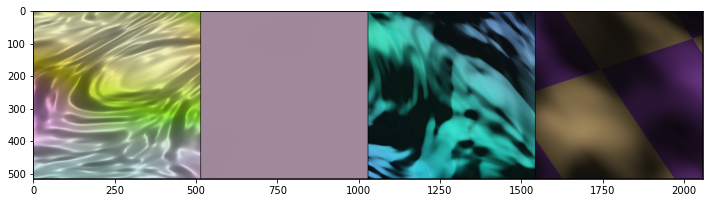

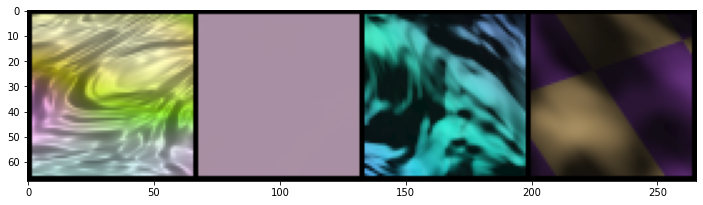

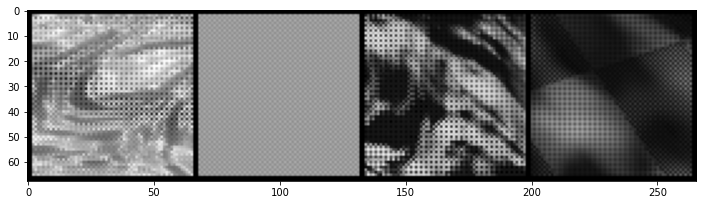

In [8]:
cam = camMosaicModelTensor()
colored, outputs = cam.develop(images)
# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(colored))
imshow(torchvision.utils.make_grid(outputs))

## demosaicnet - baseline

In [9]:
import torch as th
from collections import OrderedDict

class BayerDemosaick(nn.Module):
  """Released version of the network, best quality.
  This model differs from the published description. It has a mask/filter split
  towards the end of the processing. Masks and filters are multiplied with each
  other. This is not key to performance and can be ignored when training new
  models from scratch.
  """
  def __init__(self, depth=15, width=64, pretrained=True, pad=True):
    super(BayerDemosaick, self).__init__()

    self.depth = depth
    self.width = width

    if pad:
      pad = 1
    else:
      pad = 0

    layers = OrderedDict([
        ("pack_mosaic", nn.Conv2d(3, 4, 2, stride=2)),  # Downsample 2x2 to re-establish translation invariance
      ])
    for i in range(depth):
      n_out = width
      n_in = width
      if i == 0:
        n_in = 4
      if i == depth-1:
        n_out = 2*width
      layers["conv{}".format(i+1)] = nn.Conv2d(n_in, n_out, 3, padding=pad)
      layers["relu{}".format(i+1)] = nn.ReLU(inplace=True)

    self.main_processor = nn.Sequential(layers)
    self.residual_predictor = nn.Conv2d(width, 12, 1)
    self.upsampler = nn.ConvTranspose2d(12, 3, 2, stride=2, groups=3)

    self.fullres_processor = nn.Sequential(OrderedDict([
      ("post_conv", nn.Conv2d(6, width, 3, padding=pad)),
      ("post_relu", nn.ReLU(inplace=True)),
      ("output", nn.Conv2d(width, 3, 1)),
      ]))

    # Load weights
    if pretrained:
      assert depth == 15, "pretrained bayer model has depth=15."
      assert width == 64, "pretrained bayer model has width=64."
      state_dict = th.load('/content/bayer.pth')
      self.load_state_dict(state_dict)

  def forward(self, mosaic):
    """Demosaicks a Bayer image.
    Args:
      mosaic (th.Tensor):  input Bayer mosaic
    Returns:
      th.Tensor: the demosaicked image
    """

    # 1/4 resolution features
    features = self.main_processor(mosaic)
    filters, masks = features[:, 0:self.width], features[:, self.width:2*self.width]
    filtered = filters * masks
    residual = self.residual_predictor(filtered)

    # Match mosaic and residual
    upsampled = self.upsampler(residual)
    # cropped = _crop_like(mosaic, upsampled)

    packed = th.cat([mosaic, upsampled], 1)  # skip connection
    output = self.fullres_processor(packed)
    return output

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BayerDemosaick()

In [11]:
print(model)

BayerDemosaick(
  (main_processor): Sequential(
    (pack_mosaic): Conv2d(3, 4, kernel_size=(2, 2), stride=(2, 2))
    (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU(inplace=True)
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu6): ReLU(inplace=True)
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu7): ReLU(inplace=True)
    (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu8): ReLU(inplace=True

In [12]:
for param in model.parameters():
    param.requires_grad = False

In [13]:
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

print_model_params(model)

#total params: 560886 | #trainable params: 0


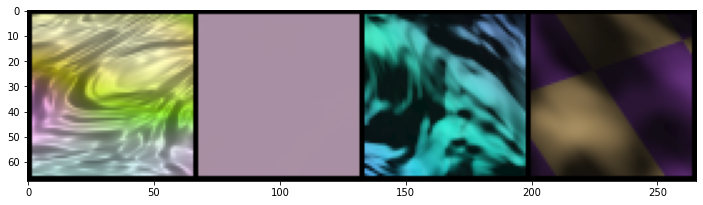

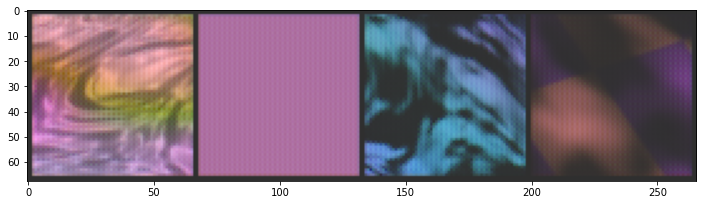

In [14]:
outputs = model(colored)
# show images
imshow(torchvision.utils.make_grid(colored))
imshow(torchvision.utils.make_grid(outputs))

### modify demosaicnet output layers to produce higher solution results

In [15]:
model.fullres_processor = nn.Sequential(OrderedDict([
      ("upsample1", nn.ConvTranspose2d(6, 64, 4, stride=2, padding=1)), 
      ("upsample_relu1", nn.ReLU(inplace=True)), 
      ("upsample2", nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)),  
      ("upsample_relu2", nn.ReLU(inplace=True)), 
      ("upsample3", nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)),
      ("upsample_relu3", nn.ReLU(inplace=True)),                      
      ("post_conv", nn.Conv2d(64, 64, 3, padding=1)),
      ("post_relu", nn.ReLU(inplace=True)),
      ("output", nn.Conv2d(64, 3, 1)),
      ]))
model = model.to(device)
print_model_params(model)
print(model)

#total params: 731702 | #trainable params: 174531
BayerDemosaick(
  (main_processor): Sequential(
    (pack_mosaic): Conv2d(3, 4, kernel_size=(2, 2), stride=(2, 2))
    (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU(inplace=True)
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu6): ReLU(inplace=True)
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu7): ReLU(inplace=True)
    (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [16]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)

In [17]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        targets = data
        inputs, _ = cam.develop(targets)
        targets = targets.to(device)
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch %d -- loss: %.3f' %
                (epoch+1, running_loss/(i+1)))
    running_loss = 0.0

print('Finished Training')

epoch 1 -- loss: 1.346
epoch 2 -- loss: 0.583
epoch 3 -- loss: 0.567
epoch 4 -- loss: 0.555
epoch 5 -- loss: 0.543
epoch 6 -- loss: 0.541
epoch 7 -- loss: 0.532
epoch 8 -- loss: 0.422
epoch 9 -- loss: 0.298
epoch 10 -- loss: 0.294
Finished Training


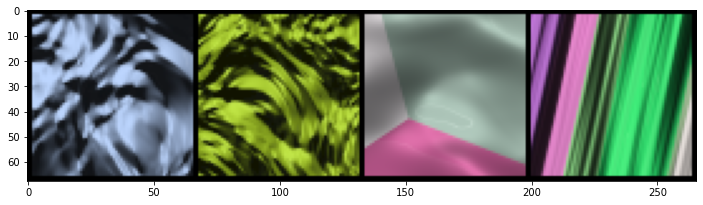

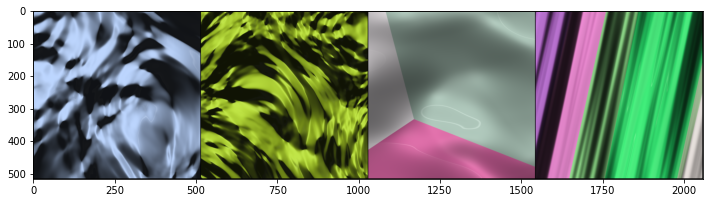

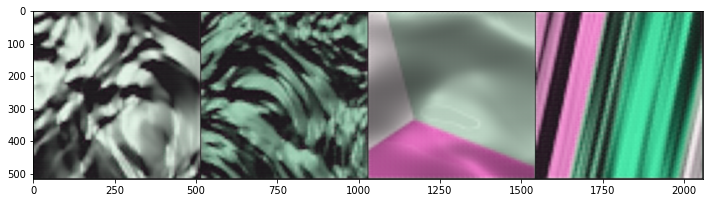

In [18]:
dataiter = iter(testloader)
targets = dataiter.next()
inputs, _ = cam.develop(targets)
outputs = model(inputs.to(device)).detach().cpu()
# show images
imshow(torchvision.utils.make_grid(inputs[:4]))
imshow(torchvision.utils.make_grid(targets[:4]))
imshow(torchvision.utils.make_grid(outputs[:4]))